# Supplementary figure: change in static stability, PV and wind in CRH-only simulations with respect to the radiation-off simulations

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys; sys.path.append("../helperfuncs")
from myfunctions import dict_expid, zlevels, load_data, domainmean_per_level, make_meancyclone

Load CRH only and radiation-off simulations.

In [2]:
explist=list()
for expid in dict_expid.keys():
    if "NORAD" in dict_expid[expid] or "CRHONLY" in dict_expid[expid]: # select simulations with no radiation or cloud-radiative heating only
        explist.append(load_data(expid=expid, chunks="auto"))

Add potential temperature to datasets.

In [3]:
def compute_theta(ds):
    ds = ds[["pres","temp"]].sel(lat=slice(80,20)).squeeze()
    theta = (ds["temp"]*np.power(1.e5/ds["pres"], 287./1005.)).compute()
    return xr.DataArray( theta, dims = ds["temp"].dims, 
                         coords= ds["temp"].coords )

for exp in explist:
    exp["theta"] = compute_theta(exp)

Add static stability to datasets.

In [4]:
def compute_drystability(ds):
    # note: we use the hard fact that height is the 2nd dimension
    drystability = np.gradient(ds["theta"].values, zlevels(), axis=1)
    # return as dataarray
    return xr.DataArray( drystability, dims = ds["temp"].dims, 
                         coords= ds["temp"].coords )

for exp in explist:
    exp["stab"] = compute_drystability(exp)

Add tropopause to datasets.

In [5]:
def compute_tropopause(ds):
    # note: only search tropopause between 3.5 km (height index 70) and 22 km (height index 30)
    pv = 1e6*ds["pv"].isel(height=slice(30,70)).squeeze()
    itrop = 30 + np.argmin(np.abs(pv.values -2), axis=1) # need to add 30 here because of height restriction above
    ztrop = zlevels()[itrop]
    return xr.DataArray( ztrop, dims = ["time", "lat", "lon"], 
                         coords=dict(time=pv.time, lat=pv.lat, lon=pv.lon) )

for exp in explist:
    exp["trop"] = compute_tropopause(exp)

Plotting.

In [6]:
def make_niceaxes(ax, panel):
    plt.xlim(0,60)
    plt.ylim(0,14)
    ax.text(0.04,0.96, panel, ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", 
        size=14, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))
    plt.xticks([0,20, 40, 60], ["0E", "20E", "40E", "60E"], fontsize=10)
    plt.yticks([0,2,4,6,8,10,12,14], [0,2,4,6,8,10,12,14], fontsize=10)
    
def make_tropopause(trop1, trop2):
    plt.plot(trop1.lon, trop1, color="forestgreen")
    plt.plot(trop2.lon, trop2, color="forestgreen", linestyle="--")

In [11]:
lev_pres=np.linspace(0,1000,21)
lev_crh=[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
lev_theta=np.array([260,265,270,275,280,285,290,295,300,305,310,315,320,325,330,340,350,360,370,390])
dlev_theta=[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
lev=np.linspace(-80,80,41); lev=lev[lev!=0]; lev_stab=lev
dlev_stab=[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
lev=np.linspace(0,400,81); lev=lev[lev!=0]; lev_wsp=lev
dlev_wsp=2*np.array([-2,-1.5,-1,-0.5,0.5,1,1.5,2])
lev_pv=np.array([-14,-12,-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10,12,14])
dlev_pv=[-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
lev=np.linspace(-50,50,21); lev=lev[lev!=0]; lev_v=lev
dlev_v=np.array([-3,-2,-1,1,2,3])

zlevels_14km = zlevels()[43:]

def make_panelplot(ds_no, ds_ch, ds_ft, ds_bl):
    
    # get data for plotting into datasets and average over the 6 cyclones
    no_trop  = make_meancyclone(ds_no["trop"]) 
    no_stab  = make_meancyclone(ds_no["stab"])
    no_theta = make_meancyclone(ds_no["theta"])
    no_pv    = 1e6*make_meancyclone(ds_no["pv"])   
    no_v     = make_meancyclone(ds_no["v"])
    no_u     = make_meancyclone(ds_no["u"])
    
    ch_trop  = make_meancyclone(ds_ch["trop"]) 
    ch_crh   = make_meancyclone(ds_ch["crh"])
    ch_stab  = make_meancyclone(ds_ch["stab"])
    ch_theta = make_meancyclone(ds_ch["theta"])
    ch_pv    = 1e6*make_meancyclone(ds_ch["pv"])
    ch_v     = make_meancyclone(ds_ch["v"])
    ch_u     = make_meancyclone(ds_ch["u"])
    
    ft_trop  = make_meancyclone(ds_ft["trop"]) 
    ft_crh   = make_meancyclone(ds_ft["crh"])
    ft_stab  = make_meancyclone(ds_ft["stab"])
    ft_theta = make_meancyclone(ds_ft["theta"])
    ft_pv    = 1e6*make_meancyclone(ds_ft["pv"])
    ft_v     = make_meancyclone(ds_ft["v"])
    ft_u     = make_meancyclone(ds_ft["u"])
    
    bl_trop  = make_meancyclone(ds_bl["trop"]) 
    bl_crh   = make_meancyclone(ds_bl["crh"])
    bl_stab  = make_meancyclone(ds_bl["stab"])
    bl_theta = make_meancyclone(ds_bl["theta"])
    bl_pv    = 1e6*make_meancyclone(ds_bl["pv"])
    bl_v     = make_meancyclone(ds_bl["v"])
    bl_u     = make_meancyclone(ds_bl["u"])
    
    lon = no_stab.lon
    
    plt.figure(figsize=(36,12))
    
    #-------------------------------------------------------
    # CRH
    #-------------------------------------------------------
    ax=plt.subplot(3,6,1)
    plt.contourf(lon,zlevels_14km, ch_crh, cmap="RdBu_r", levels=lev_crh, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "a)")
    plt.ylabel("height / km", fontsize=10, loc="top")
    plt.title(r"cloud-rad. heating / K$\,$day$^{-1}$", fontsize=16, weight="bold")
    ax.text(-0.2,0.5, "entire atmosphere", ha="center", va="center", transform=ax.transAxes, 
        size=16, weight="bold", rotation_mode="anchor", rotation=90)

    ax=plt.subplot(3,6,7)
    plt.contourf(lon,zlevels_14km, ft_crh , cmap="RdBu_r", levels=lev_crh, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "g)")
    plt.ylabel("height / km", fontsize=10, loc="top")
    ax.text(-0.2,0.5, "free troposphere", ha="center", va="center", transform=ax.transAxes, 
        size=16, weight="bold", rotation_mode="anchor", rotation=90)

    ax=plt.subplot(3,6,13)
    plt.contourf(lon,zlevels_14km, bl_crh , cmap="RdBu_r", levels=lev_crh, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "m)")
    plt.ylabel("height / km", fontsize=10, loc="top")
    plt.xlabel("deg longitude", fontsize=10, loc="right")
    ax.text(-0.2,0.5, "boundary layer", ha="center", va="center", transform=ax.transAxes, 
        size=16, weight="bold", rotation_mode="anchor", rotation=90)

    #-------------------------------------------------------
    # potential temperature
    #-------------------------------------------------------
    ax=plt.subplot(3,6,2)
    cs=plt.contour(lon,zlevels_14km, no_theta, colors="k", levels=lev_theta)
    plt.clabel(cs,inline=True,inline_spacing=5)
    plt.contourf(lon,zlevels_14km, ch_theta - no_theta , cmap="RdBu_r", levels=dlev_theta, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "b)")
    plt.title(r"potential temperature / K", fontsize=16, weight="bold")

    ax=plt.subplot(3,6,8)
    cs=plt.contour(lon,zlevels_14km, no_theta, colors="k", levels=lev_theta)
    plt.clabel(cs,inline=True,inline_spacing=5)
    plt.contourf(lon,zlevels_14km, ft_theta - no_theta , cmap="RdBu_r", levels=dlev_theta, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "h)")
  
    ax=plt.subplot(3,6,14)
    cs=plt.contour(lon,zlevels_14km, no_theta, colors="k", levels=lev_theta)
    plt.clabel(cs,inline=True,inline_spacing=5)
    plt.contourf(lon,zlevels_14km, bl_theta - no_theta , cmap="RdBu_r", levels=dlev_theta, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "n)")
    plt.xlabel("deg longitude", fontsize=10, loc="right")
    
    #-------------------------------------------------------
    # stability
    #-------------------------------------------------------
    ax=plt.subplot(3,6,3)
    cs=plt.contour(lon,zlevels_14km, no_stab, colors="k", levels=lev_stab)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ch_stab - no_stab, cmap="RdBu_r", levels=dlev_stab, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "c)")
    plt.title(r"stability / K$\,$km$^{-1}$", fontsize=16, weight="bold")
              
    ax=plt.subplot(3,6,9)
    cs=plt.contour(lon,zlevels_14km, no_stab, colors="k", levels=lev_stab)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ft_stab - no_stab, cmap="RdBu_r", levels=dlev_stab, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "i)")
    
    ax=plt.subplot(3,6,15)
    cs=plt.contour(lon,zlevels_14km, no_stab, colors="k", levels=lev_stab)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, bl_stab - no_stab, cmap="RdBu_r", levels=dlev_stab, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "o)")
    plt.xlabel("deg longitude", fontsize=10, loc="right")
    
    #-------------------------------------------------------
    # potential vorticity
    #-------------------------------------------------------
    ax=plt.subplot(3,6,4)
    cs=plt.contour(lon,zlevels_14km, no_pv, colors="k", levels=lev_pv)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ch_pv - no_pv, cmap="RdBu_r", levels=dlev_pv, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "d)")
    plt.title("potential vorticity / PVU", fontsize=16, weight="bold")
    plt.text(12,0.8,"L",fontsize=25,fontweight="bold", va="center", ha="center", color="forestgreen")
              
    ax=plt.subplot(3,6,10)
    cs=plt.contour(lon,zlevels_14km, no_pv, colors="k", levels=lev_pv)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ft_pv - no_pv, cmap="RdBu_r", levels=dlev_pv, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "j)")
    
    ax=plt.subplot(3,6,16)
    cs=plt.contour(lon,zlevels_14km, no_pv, colors="k", levels=lev_pv)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, bl_pv - no_pv, cmap="RdBu_r", levels=dlev_pv, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "p)")
    plt.xlabel("deg longitude", fontsize=10, loc="right")
    
    #-------------------------------------------------------
    # zonal wind speed
    #-------------------------------------------------------
    ax=plt.subplot(3,6,5)
    cs=plt.contour(lon,zlevels_14km, no_u, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ch_u - no_u , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "e)")
    plt.title(r"zonal wind / m$\,$s$^{-1}$", fontsize=16, weight="bold")

    ax=plt.subplot(3,6,11)
    cs=plt.contour(lon,zlevels_14km, no_u, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ft_u - no_u , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "k)")
    
    ax=plt.subplot(3,6,17)
    cs=plt.contour(lon,zlevels_14km, no_u, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, bl_u - no_u , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "q)")
    plt.xlabel("deg longitude", fontsize=10, loc="right")
       
    #-------------------------------------------------------
    # meridional wind speed
    #-------------------------------------------------------
    ax=plt.subplot(3,6,6)
    cs=plt.contour(lon,zlevels_14km, no_v, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ch_v - no_v , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ch_trop); make_niceaxes(ax, "f)")
    plt.title(r"meridional wind / m$\,$s$^{-1}$", fontsize=16, weight="bold")

    ax=plt.subplot(3,6,12)
    cs=plt.contour(no_v.lon,zlevels_14km, no_v, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, ft_v - no_v , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, ft_trop); make_niceaxes(ax, "l)")
    
    ax=plt.subplot(3,6,18)
    cs=plt.contour(lon,zlevels_14km, no_v, colors="k", levels=lev_v)
    plt.clabel(cs,inline=True,inline_spacing=0)
    plt.contourf(lon,zlevels_14km, bl_v - no_v , cmap="RdBu_r", levels=dlev_v, extend="both"); plt.colorbar()
    make_tropopause(no_trop, bl_trop); make_niceaxes(ax, "r)")
    plt.xlabel("deg longitude", fontsize=10, loc="right")

Below we plot the time-mean between day 5 and 6.5. For reference, we here plot the surface pressure field averaged between day 5 and 6.5 to check the location of the cyclone. Note that we need to apply "make_meancyclone". We find that the cyclone is located at around 12 deg E. We use this information in the plots to indicate the longitudinal position of the cyclone with a "L".

Text(0, 0.5, 'latitude')

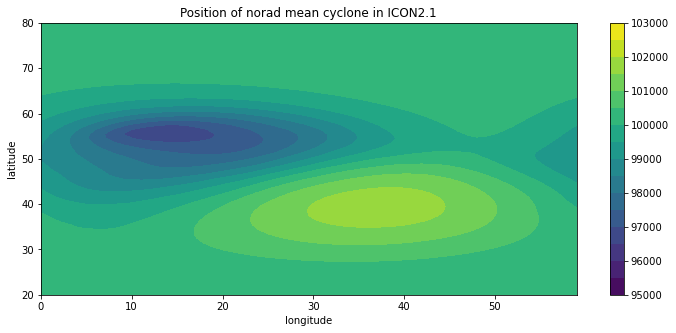

In [8]:
no21_pres_sfc  = make_meancyclone(explist[0]["pres_sfc"].isel(time=slice(20,26)).mean("time")) 

pres_lev=100*np.linspace(950,1030,17)

plt.figure(figsize=(12,5))

plt.contourf(no21_pres_sfc.lon,no21_pres_sfc.lat,no21_pres_sfc, levels=pres_lev)
plt.colorbar()
plt.ylim(20,80)
plt.title("Position of norad mean cyclone in ICON2.1")
plt.xlabel("longitude"); plt.ylabel("latitude")

ICON2.1.

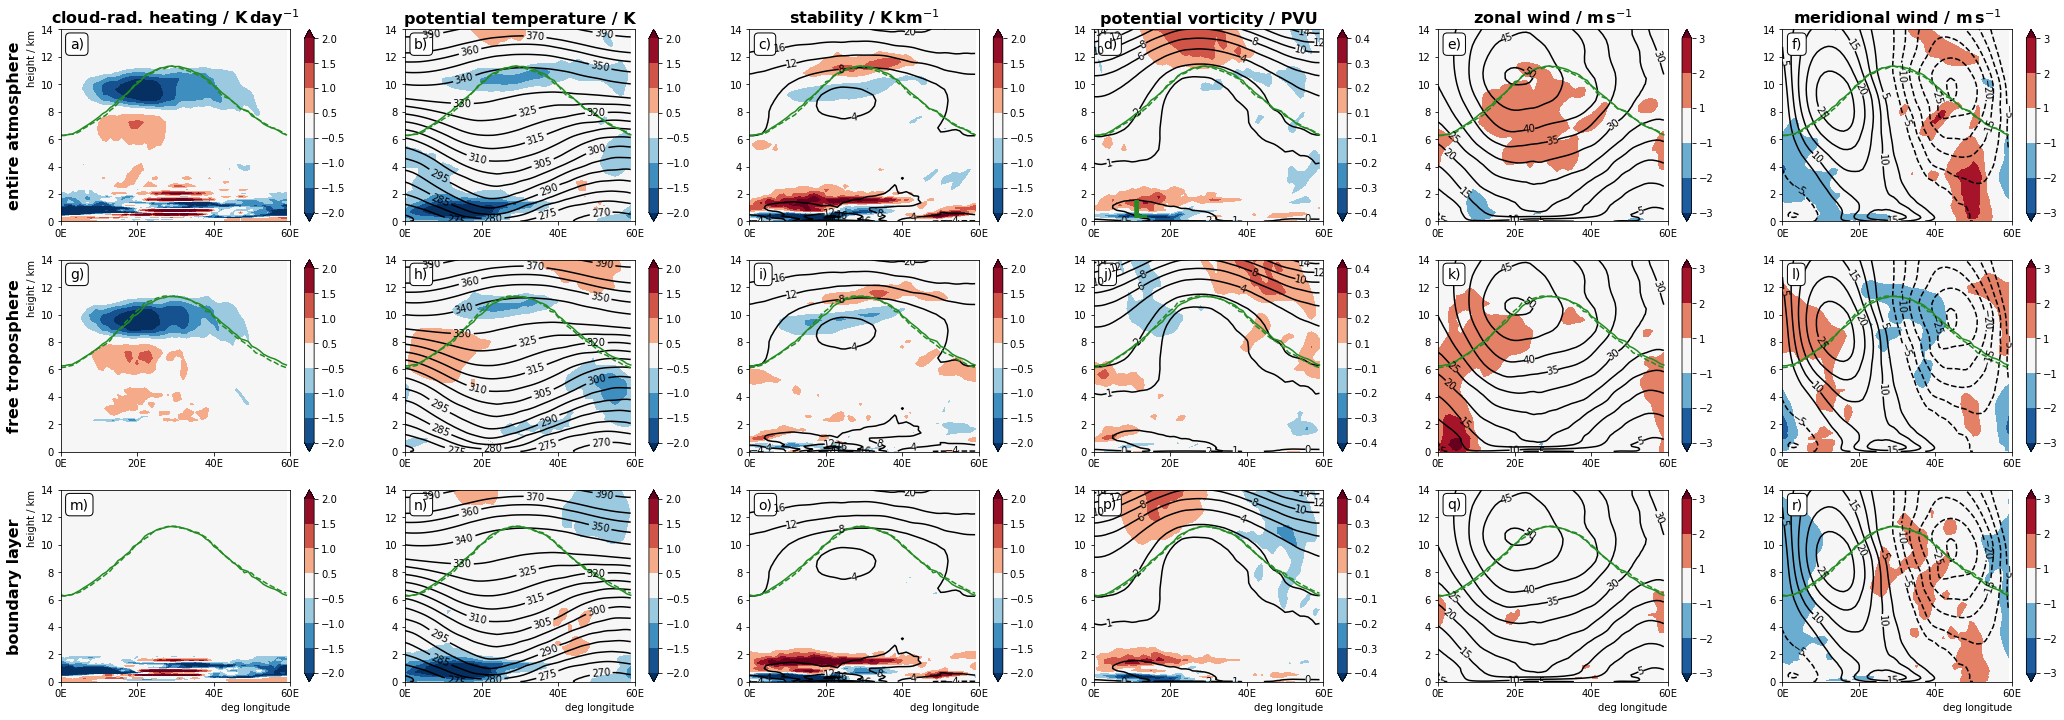

In [12]:
ds_no = explist[0].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_ch = explist[1].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_bl = explist[2].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_ft = explist[4].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
make_panelplot(ds_no, ds_ch, ds_ft, ds_bl)
plt.savefig("figure_supp_stability_pv_wind_icon21.pdf")

ICON2.6.

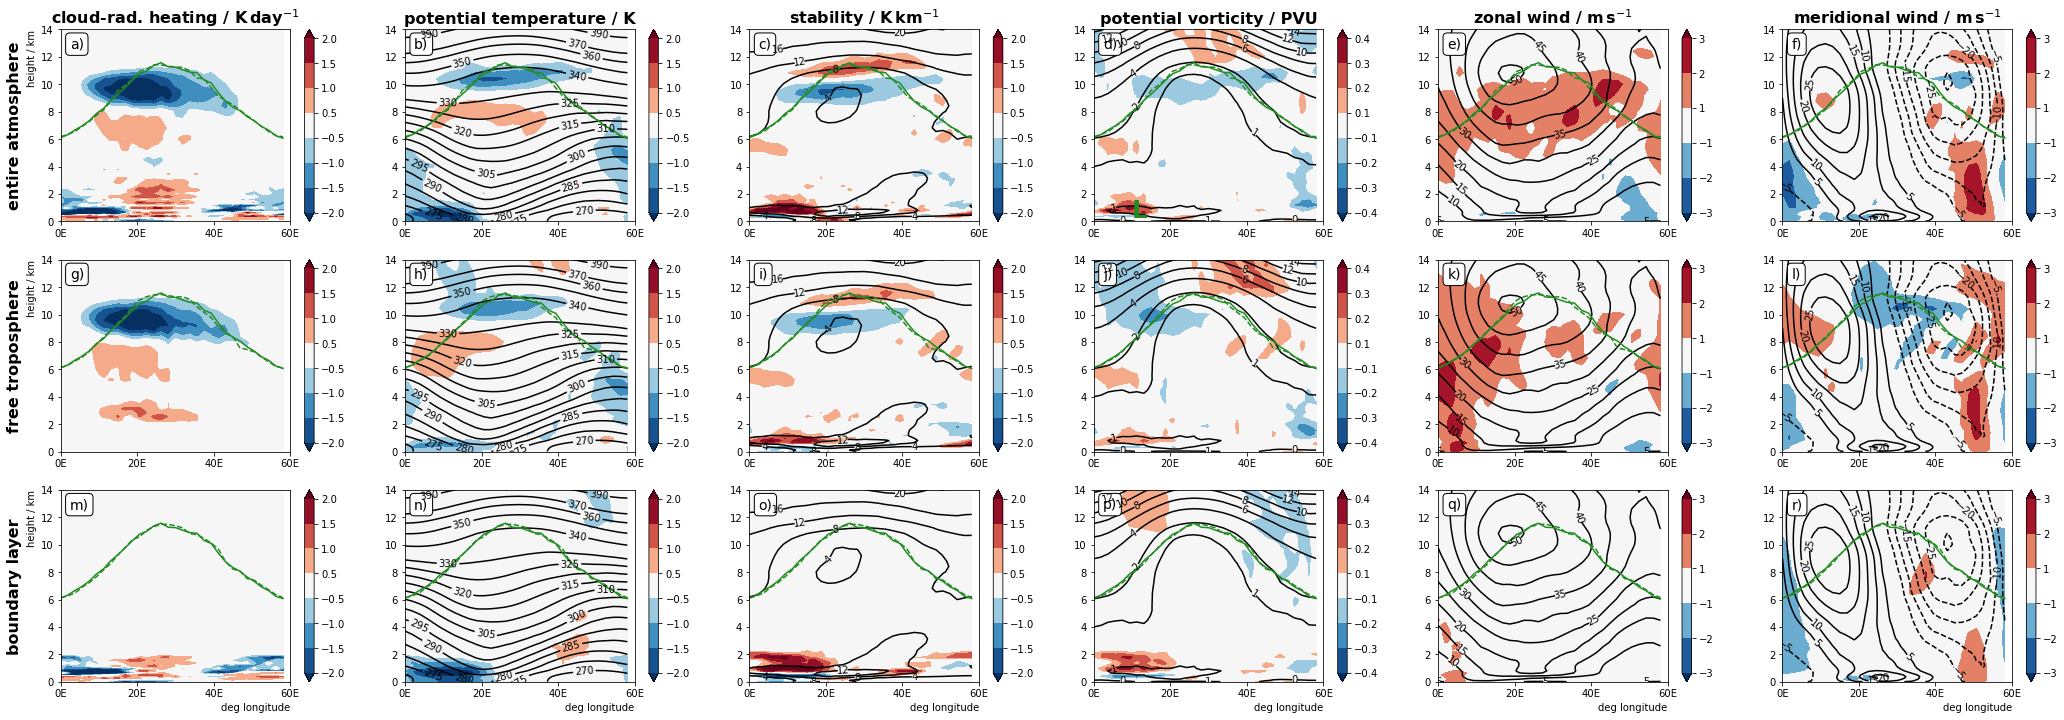

In [13]:
ds_no = explist[5].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_ch = explist[6].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_bl = explist[7].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
ds_ft = explist[8].isel(time=slice(20,26)).mean("time").sel(lat=slice(55,45)).mean("lat").isel(height=slice(43,90))
make_panelplot(ds_no, ds_ch, ds_ft, ds_bl)
plt.savefig("figure_supp_stability_pv_wind_icon26.pdf")